# Complexity scaling of calibration

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.optimizers import Adam, SGD

%aimport utils
%aimport utils.data
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot
from utils.visualization import reliability_diagram, ECE_plot, plot_cal_regions_ternary
from flows.nice import AddCouplingLayer, MLP, ReIndex
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator, TempScalingCalibrator

In [4]:
%matplotlib inline
np.random.seed(1)

In [5]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

## CNN trained on CIFAR3 vs CNN trained on CIFAR10

### Loading datasets

In [6]:
cifar3, ix2label3 = get_cifar3(cifar_dir, test=True)
target3 = onehot_encode(cifar3['test_labels'])

cifar10, ix2label10 = get_cifar10(cifar_dir, test=True)
target10 = onehot_encode(cifar10['test_labels'])

### Loading models

In [31]:
model_c3 = 'cnn_cifar3'
model_c10 = 'resnet56_v2'

_, logits3 = load_logits(os.path.join(models_dir, model_c3))
probs3 = softmax(logits3, axis=1)

_, logits10 = load_logits(os.path.join(models_dir, model_c10))
probs10 = softmax(logits10, axis=1)

### Judging misscalibration

In [32]:
cnn3_ece = expected_calibration_error(probs3, target3)
cnn10_ece = expected_calibration_error(probs10, target10)

cnn3_nll = neg_log_likelihood(probs3, target3)
cnn10_nll = neg_log_likelihood(probs10, target10)

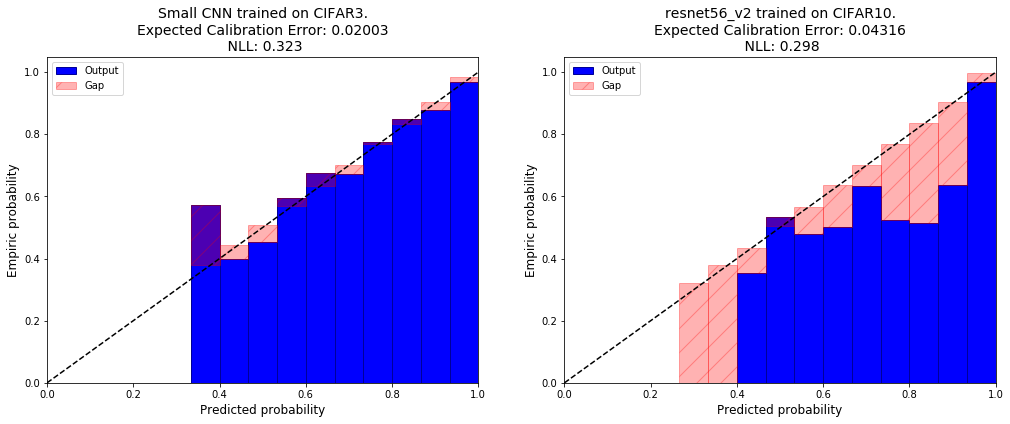

In [33]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))


ax_arr[0] = reliability_diagram(probs3, target3, ax=ax_arr[0], title='Small CNN trained on CIFAR3.'+
                                '\nExpected Calibration Error: {:.5f}'.format(cnn3_ece) +
                                '\n NLL: {:.3f}'.format(cnn3_nll), bins=15)
ax_arr[1] = reliability_diagram(probs10, target10, ax=ax_arr[1], title='resnet56_v2 trained on CIFAR10.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(cnn10_ece) +
                                '\n NLL: {:.3f}'.format(cnn10_nll), bins=15)

plt.show();

fig.savefig('../images/reliability-diagrams-example.png')

### Compute optimum calibration for each model

#### CNN trained on CIFAR3:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted in 146.731s


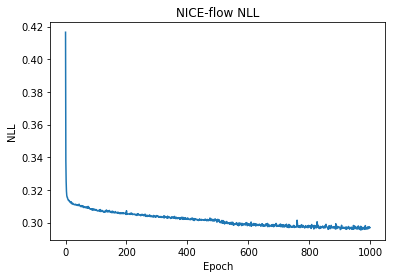

In [10]:
t0 = time.time()
nice_cal_c3 = NiceCalibrator(logits3, target3, layers=4, hidden_size=[5, 5],
                          version=2, batch_size=50)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal_c3.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

#### CNN trained on CIFAR10:

Fitted in 529.607s


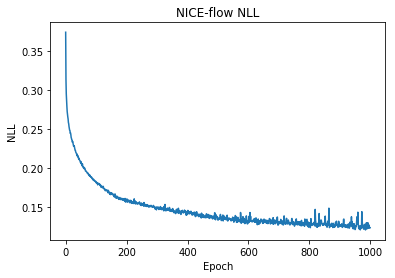

In [11]:
t0 = time.time()
nice_cal_c10 = NiceCalibrator(logits10, target10, layers=4, hidden_size=[10, 10], epochs=1000, batch_size=50)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal_c10.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

### Judging calibration

In [12]:
cal_probs3 = nice_cal_c3.predict(logits3)
cal_probs10 = nice_cal_c10.predict(logits10)

# Expected calibration error
cal_cnn3_ece = expected_calibration_error(cal_probs3, target3)
cal_cnn10_ece = expected_calibration_error(cal_probs10, target10)

# Negative Log-likelihood
cal_cnn3_nll = neg_log_likelihood(cal_probs3, target3)
cal_cnn10_nll = neg_log_likelihood(cal_probs10, target10)

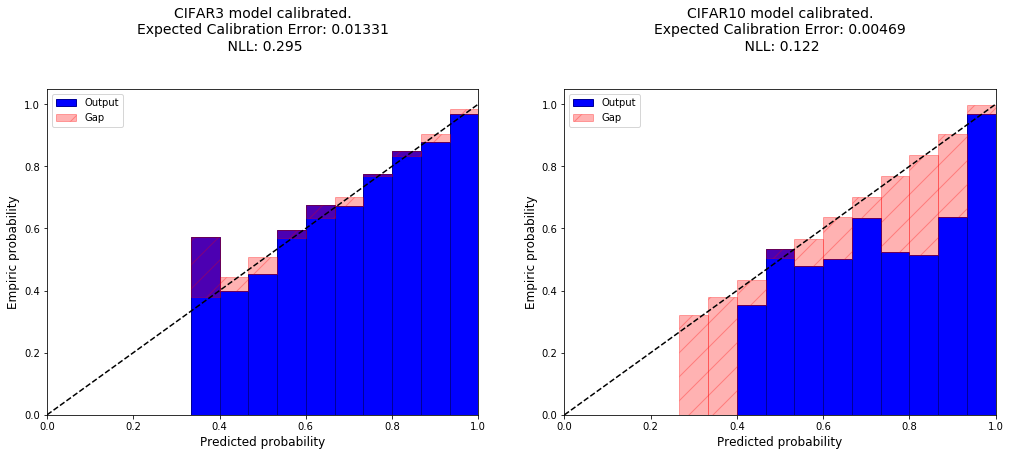

In [13]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))


ax_arr[0] = reliability_diagram(probs3, target3, ax=ax_arr[0], title='CIFAR3 model calibrated.'+
                                '\nExpected Calibration Error: {:.5f}'.format(cal_cnn3_ece) +
                                '\n NLL: {:.3f}'.format(cal_cnn3_nll), bins=15)
ax_arr[1] = reliability_diagram(probs10, target10, ax=ax_arr[1], title='CIFAR10 model calibrated.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(cal_cnn10_ece) +
                                '\n NLL: {:.3f}'.format(cal_cnn10_nll), bins=15)

plt.show();

#### Calibration regions on CIFAR3

In [14]:
def nice_cal_c10_wrapped(logits):
    probs = softmax(logits, axis=1)
    padded_probs = np.zeros((logits.shape[0], 10))
    padded_probs[:, :3] = probs
    
    new_logits = np.log(padded_probs + 1e-10)
    cal_logits = nice_cal_c10.predict_logits(new_logits)
    
    return softmax(cal_logits[:, :3], axis=1)

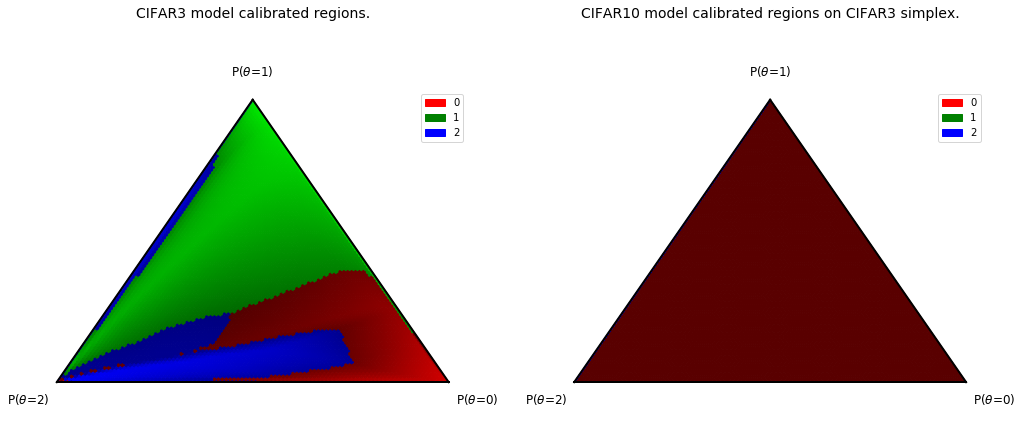

In [15]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))


ax_arr[0] = plot_cal_regions_ternary(nice_cal_c3, ax=ax_arr[0], scale=100,
                                     title='CIFAR3 model calibrated regions.\n\n', fontsize=12);
ax_arr[1] = plot_cal_regions_ternary(nice_cal_c10_wrapped, ax=ax_arr[1], scale=100,
                                     title='CIFAR10 model calibrated regions on CIFAR3 simplex.\n\n', fontsize=12);

plt.show();